In [64]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scvelo as scv
from scipy import stats
import os
import matplotlib
%matplotlib inline

import random
np.random.seed(0)
random.seed(0)


import scipy as sp

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sc.settings.verbosity = 0  


# Loading data

In [10]:

def save_intermediate_files(datasets, temp_dir, file_name_template, identifier):
    for d in datasets:
        file = os.path.join('.', temp_dir, file_name_template + '_' + d.obs[identifier][0] + '.h5ad')
        d.write(file, compression='gzip')
        
identifiers = ['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27']
      
def load_intermediate_files(temp_dir, file_name_template, identifiers):
    ob_list = []
    for i in identifiers:
        file = os.path.join('.', temp_dir, file_name_template + '_' + i+ '.h5ad')
        ob_list.append(sc.read_h5ad(file))
    return ob_list

In [11]:

st08_z_raw, st105_z_raw, st12_z_raw, st13_z_raw, st16_z_raw, st18_z_raw, st20_z_raw, st22_z_raw, st24_z_raw, st27_z_raw = load_intermediate_files( 'intermediate_files', 'zUMI_Unprocessed' , identifiers)
datasets_z_raw = st08_z_raw, st105_z_raw, st12_z_raw, st13_z_raw, st16_z_raw, st18_z_raw, st20_z_raw, st22_z_raw, st24_z_raw, st27_z_raw


In [12]:
st08_z, st105_z, st12_z, st13_z, st16_z, st18_z, st20_z, st22_z, st24_z, st27_z = load_intermediate_files( 'intermediate_files', 'zUMI_raw_singlets' , identifiers)


datasets_z = [st08_z, st105_z, st12_z, st13_z, st16_z, st18_z, st20_z, st22_z, st24_z, st27_z]

In [13]:
def cut_zumi(bc):
    return bc.split(':')[1].strip('x')

for idx, i in enumerate(datasets_z_raw):
    datasets_z_raw[idx].obs_names = [cut_zumi(bc) for bc in datasets_z_raw[idx].obs_names]

# Merging data

In [40]:
adata1 = st08_z_raw[st08_z.obs_names].copy()
adata2 = st105_z_raw[st105_z.obs_names].copy()
adata3 = st12_z_raw[st12_z.obs_names].copy()
adata4 = st13_z_raw[st13_z.obs_names].copy()
adata5 = st16_z_raw[st16_z.obs_names].copy()
adata6 = st18_z_raw[st18_z.obs_names].copy()
adata7 = st20_z_raw[st20_z.obs_names].copy()
adata8 = st22_z_raw[st22_z.obs_names].copy()
adata9 = st24_z_raw[st24_z.obs_names].copy()
adata10 = st27_z_raw[st27_z.obs_names].copy()



adatas = [adata1, adata2, adata3, adata4, adata5, adata6, adata7, adata8, adata9, adata10]
unspliceds = [ad.layers['unspliced'] for ad in adatas]
unspliced  = unspliceds[0]
for m in unspliceds[1:]:
    unspliced = sp.sparse.vstack([unspliced, m])

adata = adatas[0].concatenate(
    adatas[1:], batch_key='stage', batch_categories=identifiers)

adata.layers['spliced'] = adata.X
adata.layers['unspliced'] = unspliced


## Add cluster information

In [41]:
def move_identifier(ls):
    return ['_'.join(i.split('-')[::-1]) for i in ls]

In [42]:
adata.obs_names = move_identifier(adata.obs_names)
    

In [43]:
import pickle
    
with open('./intermediate_files/clusters', "rb") as f:
    clusters = pickle.load( f)

In [44]:
adata.obs['cluster'] = clusters

In [45]:
from Integrate import concat_for_harmony, adata_to_df
import harmony
counts = concat_for_harmony(adatas, identifiers)
norm_df = harmony.utils.normalize_counts(counts)
hvg_genes = harmony.utils.hvg_genes(norm_df, no_genes=2000)
data_df = harmony.utils.log_transform(norm_df.loc[:,hvg_genes])


st08
st10.5
st12
st13
st16
st18
st20
st22
st24
st27
Concatenating data..


In [46]:
tp = pd.Series(index=data_df.index)
for t in identifiers:
    cells = data_df.index[data_df.index.str.contains(t)]
    tp[cells] = t

In [47]:
adata.obs['stage'] = tp

## Make the subsets

In [48]:
basal = adata[adata.obs['cluster'].isin([14, 12, 6, 3])].copy()

mcc = adata[adata.obs['cluster'].isin([9, 10, 13])].copy()

ion = adata[adata.obs['cluster'].isin([11])].copy()

goblet = adata[adata.obs['cluster'].isin([8])].copy()

pluri = adata[adata.obs['cluster'].isin([7, 4])].copy()

progen = adata[adata.obs['cluster'].isin([0, 2, 1, 5])].copy()

## Preprocess

In [51]:
def preprocess(anndata):
    sc.pp.normalize_per_cell(anndata, counts_per_cell_after=1e4)
    sc.pp.log1p(anndata)
    sc.pp.highly_variable_genes(anndata, min_mean=0.0125, max_mean=3, min_disp=0.3)
    anndata = anndata[:, anndata.var.highly_variable]
    sc.pp.scale(anndata)
    scv.pp.filter_and_normalize(anndata, min_counts=10, n_top_genes=1000)
    return anndata

In [53]:
for i in range(len(adatas)):
    adatas[i] = preprocess(adatas[i])

Filtered out 1834 genes that are detected 10 counts (spliced).
Normalized count data: spliced, unspliced.
Extracted 2571 highly variable genes.
Filtered out 1746 genes that are detected 10 counts (spliced).
Normalized count data: spliced, unspliced.
Extracted 2730 highly variable genes.
Filtered out 1841 genes that are detected 10 counts (spliced).
Normalized count data: spliced, unspliced.
Extracted 2634 highly variable genes.
Filtered out 1694 genes that are detected 10 counts (spliced).
Normalized count data: spliced, unspliced.
Extracted 2676 highly variable genes.
Filtered out 2158 genes that are detected 10 counts (spliced).
Normalized count data: spliced, unspliced.
Extracted 2031 highly variable genes.
Filtered out 1437 genes that are detected 10 counts (spliced).
Normalized count data: spliced, unspliced.
Extracted 2605 highly variable genes.
Filtered out 1986 genes that are detected 10 counts (spliced).
Normalized count data: spliced, unspliced.
Extracted 2432 highly variable

## Prep layouts

In [55]:
def prep_coord(path, row_names):
    spring = pd.read_csv(path, header = None, index_col = None)
    spring.columns = ['x', 'y']
    spring.index = row_names
    return spring


coords = []
for i in range(len(adatas)):
    coords.append(prep_coord('Ind_coord/umap_coord_{}.txt'.format(identifiers[i]), adatas[i].obs_names))
                                        
                                        

# Run velocyto

In [56]:
stage_colors = {x:y for x,y in zip(identifiers,sns.color_palette(
            'rainbow', 10))}

In [57]:
#setting color themes

stage_colors = pd.Series(sns.color_palette(
            'rainbow', 10), index=identifiers)

clust_colors = [
[(0.3388235294117647, 0.7117262591311034, 0.40584390618992694),0, 2],
[(0.7371472510572856, 0.895517108804306, 0.7108342945021145),1, 4],
[(0.5573241061130334, 0.8164244521337947, 0.546958861976163),2, 3],
[(0.7364705882352941, 0.08, 0.10117647058823528),3, 9],
[(0.7777777777777778, 0.7777777777777778, 0.7777777777777778),4, 1],
[(0.8828143021914648, 0.9546943483275664, 0.8621914648212226),5, 5],
[(0.9466666666666667, 0.26823529411764707, 0.19607843137254902),6, 8],
[(0.586082276047674, 0.586082276047674, 0.586082276047674),7, 0],
[(0.996078431372549, 0.8091503267973856, 0.39607843137254906),8, 14],
[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897),9, 10],
[(0.41708573625528644, 0.6806305267204922, 0.8382314494425221),10, 11],
[(0.5513264129181085, 0.537916186082276, 0.7524490580545944),11, 13],
[(0.9874509803921568, 0.5411764705882353, 0.41568627450980394),12, 7],
[(0.1271049596309112, 0.4401845444059977, 0.7074971164936563),13, 12],
[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471),14, 6]]
clust_colors = pd.DataFrame(clust_colors, columns = ['color', 'org_clust', 'clust_order'])

In [25]:
import magic
def magic_impute(anndata, knn=20, t=3, verbose=0, **kwargs):
    magic_operator = magic.MAGIC(verbose=verbose, knn=knn, t=t, **kwargs)
    anndata.layers['spliced'] = magic_operator.fit_transform(anndata.layers['spliced'])
    anndata.layers['unspliced'] = magic_operator.transform(anndata.layers['unspliced'])

In [58]:
for i in range(len(adatas)):
    adatas[i].obs_names = tp[tp == identifiers[i]].index
    adatas[i].obs.index = tp[tp == identifiers[i]].index
    adatas[i].obs['stage'] = tp[tp == identifiers[i]]
    adatas[i].obs['cluster'] = clusters[tp == identifiers[i]].map(str)

In [59]:
def run_scvelo(anndata, layout):
    #magic_impute(anndata)
    scv.pp.moments(anndata, n_pcs = 10, n_neighbors=50)
    
    scv.tl.velocity(anndata, mode='stochastic')
    scv.tl.velocity_graph(anndata)
    sc.pp.neighbors(anndata)
    sc.tl.umap(anndata)
    anndata.obsm['X_umap'] = np.array(layout)
    return anndata

In [60]:
for i in range(len(adatas)):
    adatas[i] = run_scvelo(adatas[i], coords[i])
    

computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
 

In [61]:
cmap = {str(i):c for i,c in zip(clust_colors.index, clust_colors.color.values)}

In [62]:
clust_colors.index = [str(x) for x in clust_colors.index]

In [63]:
ax = scv.pl.velocity_embedding_grid(adatas[7], 
                                    basis='umap',
                                    color = 'cluster',
                                    figsize = (10,10), 
                                    size = 100,
                                    palette=clust_colors.color.to_dict(), 
                                    alpha = 0.5, 
                                    arrow_size=(2), 
                                    smooth = 1.5, 
                                    min_mass = 30,
                                    scale = 0.3,
                                    show = False)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


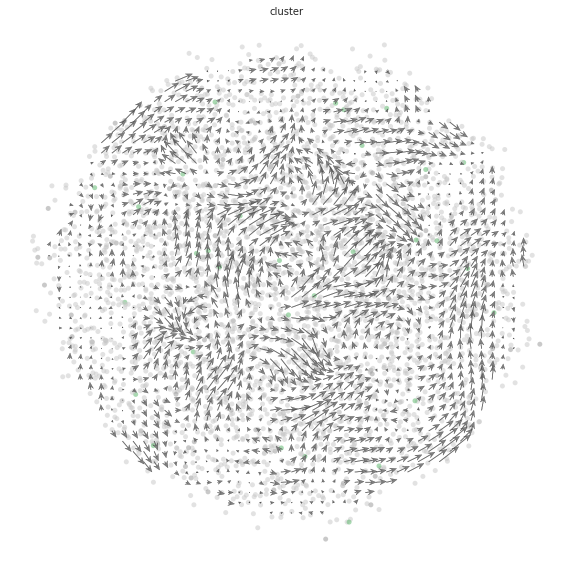

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


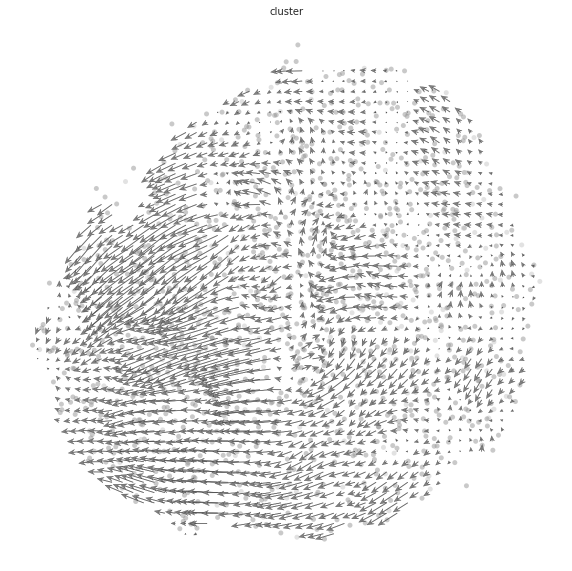

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


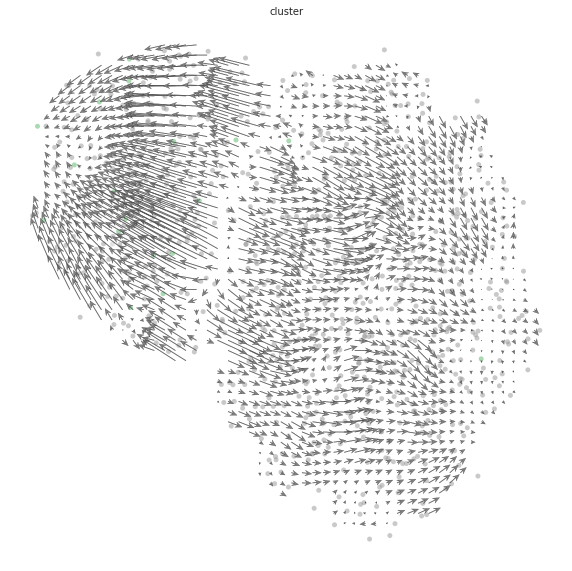

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


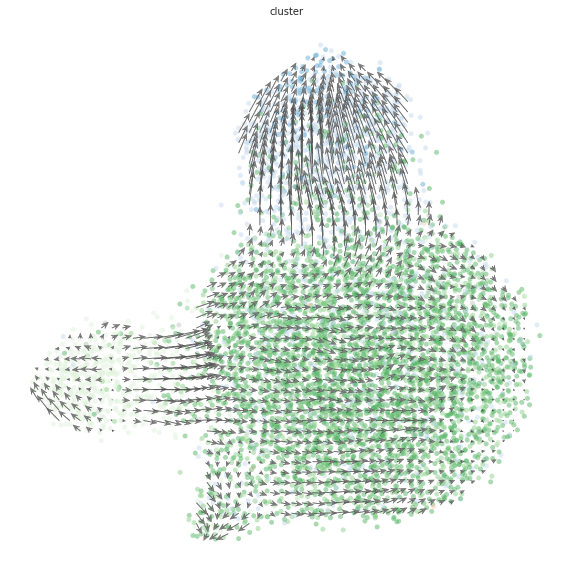

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


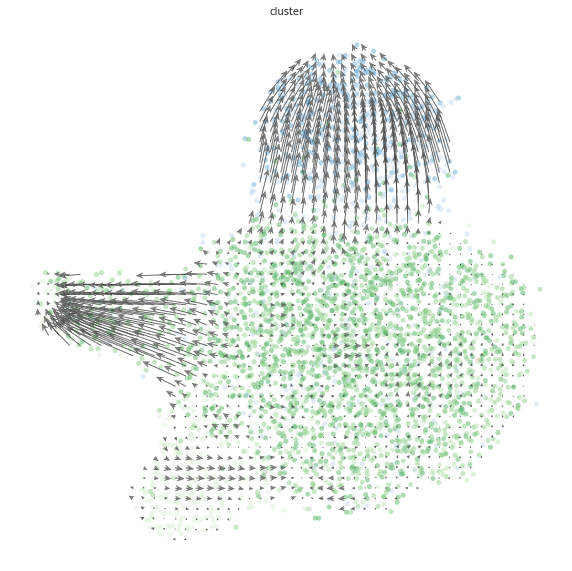

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


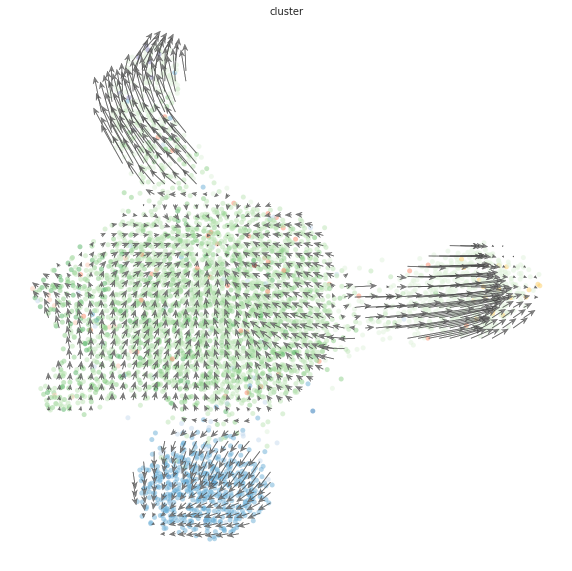

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


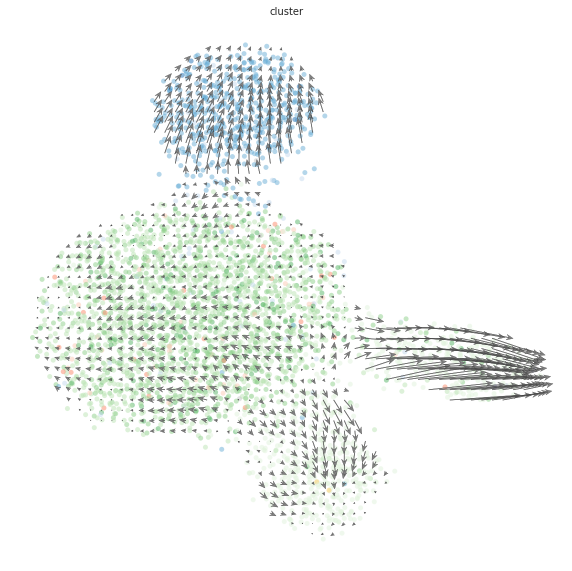

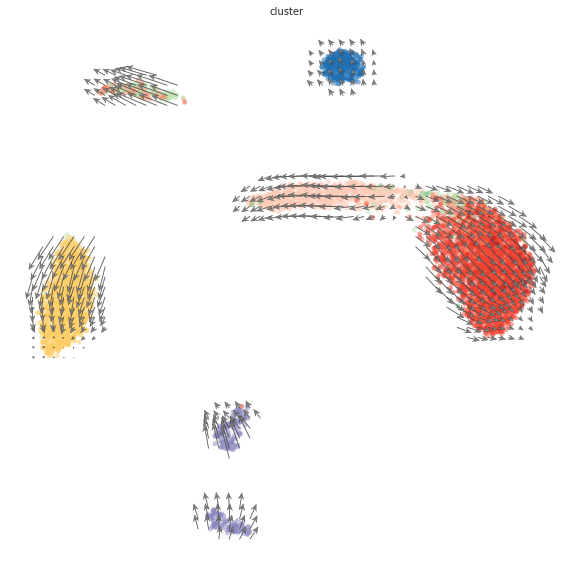

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


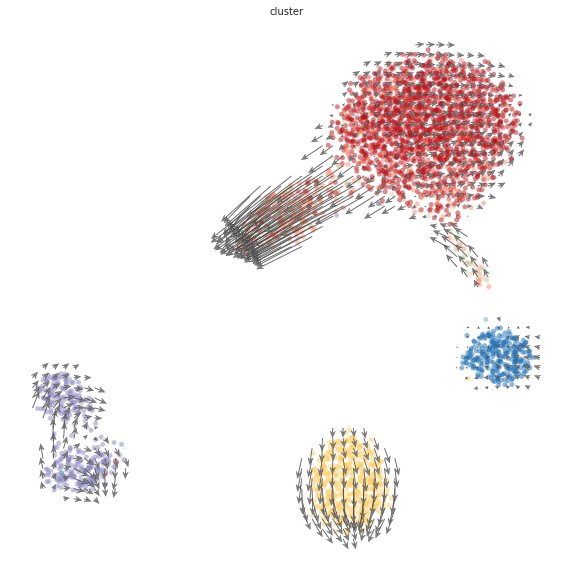

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


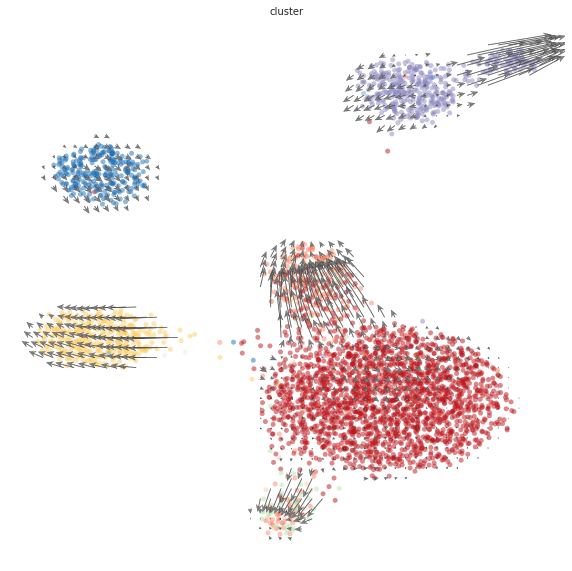

In [65]:
for i in range(len(adatas)):
    ax = scv.pl.velocity_embedding_grid(adatas[i], 
                                    basis='umap',
                                    color = 'cluster',
                                    figsize = (10,10), 
                                    size = 100,
                                    palette=clust_colors.color.to_dict(), 
                                    alpha = 0.5, 
                                    arrow_size=(2), 
                                    smooth = 1.5, 
                                    min_mass = 30,
                                    scale = 0.3,
                                    show = False)
    ax.set_rasterized(True)

    plt.savefig('figures/velocyto_stage_grid_{}.pdf'.format(identifiers[i]),dpi = 500 )
    plt.show()
